<a href="https://colab.research.google.com/github/Samadsia/PointNetModel/blob/main/Finalized%20_%20PointCloudPointNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of Point Clouds with PointNet

Importing required libraries
And a random seed for the random number generators in TensorFlow

In [44]:
!pip install trimesh
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(2025)

By Colab, using availible GPU

In [45]:
# Use hardware accelerator for training
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPUs Available:  1


## To download the dataset, here ModelNet10 is used.
ModelNet40 is also applicable

In [46]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

## Visualize a Mesh from the Dataset
A visualization of a sample object by our applied data set(ModelNet10)
By modifying the directory, other objects will be shown below.

In [50]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0022.off"))
mesh.show()

## Sample a mesh and showing result

To visualize a sampled point cloud from a 3D mesh, and creating a new figure for plotting and adding a 3D subplot to it. The figsize parameter sets the size of the figure.Finally, the points array is indexed to get the x, y, and z coordinates of each point.

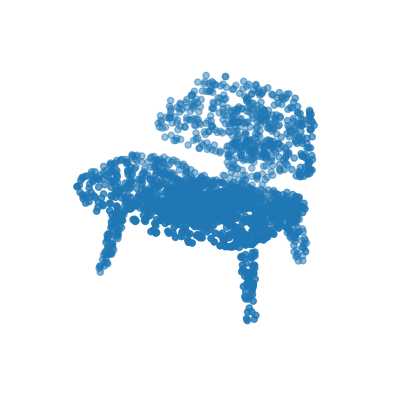

In [49]:
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

## Function to parse data
- Each mesh is loaded and sampled into a point cloud and is returned as a numpy array. In fact, here is to loading, processing, and organizing the dataset into a format suitable for training and testing the model

In [13]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

## Parsed the Dataset and Process each Class
This step sets the key parameters for the model and prepares the dataset by parsing the point clouds and labels for training and testing. This data is then used to train and evaluate the PointNet model.

In [14]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS)

processing class: chair
processing class: bathtub
processing class: toilet
processing class: desk
processing class: dresser
processing class: sofa
processing class: monitor
processing class: night_stand
processing class: bed
processing class: table


## Augenmentation for Train Dataset
By **Jitter**, we can add a small random noise to each point in the point cloud. The noise is uniformly distributed between -0.005 and 0.005. This helps the model generalize better by making it more robust to slight variations in the input data. And also, randomly **shuffles** the order of the points in the point cloud. Shuffling helps the model learn to recognize the shape of the object regardless of the order of the points.

In [15]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

## Functions to build the Model
Creating a 1D convolutional layer by the defined function and followed by batch normalization and a **ReLU** activation (Normalizes the output of the convolutional layer to improve training stability and performance.) the ReLU activation function is used to introduce non-linearity which helps our model to
learn complex patterns. ReLU is commonly used because it is computationally
efficient and helps mitigate the vanishing gradient problem.
x: The input tensor.
filters: The number of units (neurons) for the dense layer.
**Note1**: A kernel size of 1 means that the convolution operation is applied to each point individually without considering its neighbors. This is useful in PointNet because it allows the network to learn features for each point independently before combining them in later layers.
**Note2**: The momentum parameter controls the moving average of the mean and variance of the features. A momentum of 0.0 means that the statistics are computed using only the current batch, without considering previous batches. This can be useful in scenarios where the batch size is large enough to provide stable statistics or when the data distribution changes rapidly.
In the follwoing, creating a dense layer (Fully connected layer) followed by batch normalization and a ReLU activation. Here again, x is the input tensor and
filters are the number of units (neurons) for the dense layer.


In [16]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

Here, this class implements **a custom regularizer** that encourages the learned transformation matrices to be orthogonal. This is particularly useful in the T-Net layers of PointNet to ensure that the transformations are valid rotations or reflections.
The parameters are num_features which shows the number of features (dimensions) of the input and also l2reg that is the regularization strength.

**Importance of T-Net:** these layers of PointNet. The T-Net layers are responsible for learning affine transformations that align the input point clouds. The OrthogonalRegularizer ensures that these transformations are orthogonal, which is important for maintaining the geometric integrity of the point clouds.

In [23]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

    def get_config(self):
        return {"num_features": self.num_features, "l2reg": self.l2reg}

Above, we have two functions, as conv_bn and dense_bn  which are used to build the layers of the PointNet model. They ensure that each layer has batch normalization and ReLU activation, which are essential for stable and efficient training.
Then, the OrthogonalRegularizer ensures that the learned transformations in the T-Net layers are orthogonal.
**Together**, they contribute to the stability, efficiency, and geometric correctness of the PointNet model.

## Function to create **T-net** Layers
The T-Net in PointNet learns an affine transformation matrix to align the input point cloud. It uses convolutional and dense layers with batch normalization and ReLU activation to extract features, followed by a dense layer that outputs the transformation matrix. This matrix is then applied to the input points to ensure geometric invariance. The OrthogonalRegularizer ensures the transformation is close to orthogonal.
The transformation matrix feat_T is learned to align the input point cloud.
Dot Product: The layers.Dot layer performs a dot product between the input features and the transformation matrix.
Axes Specification: axes=(2, 1) specifies the axes along which the dot product is computed, ensuring the correct matrix multiplication.
This operation transforms the input points using the learned matrix, making the model invariant to geometric transformations.

In [24]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

## Creating the CNN
This Convolutional Neural Network (CNN) is part of the PointNet architecture, designed for point cloud classification. Here the input shape is (NUM_POINTS, 3), where NUM_POINTS is the number of points in each point cloud, and 3 represents the x, y, and z coordinates of each point. x = conv_bn(x, 32), these layers apply 1D convolutions with 32 filters each, followed by batch normalization and ReLU activation. They learn local features from the point cloud.The first T-Net learns an affine transformation to align the input point cloud, ensuring geometric invariance and the second T-Net is applied to learn a transformation for the feature space, ensuring the learned features are invariant to geometric transformations.In the following, There are some additional layers to further process the features with increasing filter sizes (32, 64, 512), learning more complex and abstract representations.The x=layers.GlobalMaxPooling1D()(x) is a layer to aggregate the features from all points by taking the maximum value for each feature dimension, resulting in a fixed-size feature vector. Dropout layers with a rate of 0.3 are used to prevent overfitting by randomly setting a fraction of input units to zero during training. there are two layers apply fully connected layers with 256 and 128 units, respectively, followed by batch normalization and ReLU activation.
The final dense layer has NUM_CLASSES units with a softmax activation, producing a probability distribution over the classes.
This architecture ensures that the model can effectively learn and classify 3D point clouds while being invariant to geometric transformations.

In [25]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 2048, 3)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_11 (Conv1D)        │ (None, 2048, 32)       │            128 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 2048, 32)       │            128 │ conv1d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_17             │ (None, 2048, 32)       │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_12 (Conv1D)        │ (None, 2048, 64)       │          2,112 │ activation_17[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 2048, 64)       │            256 │ conv1d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 2048, 64)       │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_13 (Conv1D)        │ (None, 2048, 512)      │         33,280 │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 2048, 512)      │          2,048 │ conv1d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 2048, 512)      │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_3    │ (None, 512)            │              0 │ activation_19[0][0]    │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 256)            │        131,328 │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 256)            │          1,024 │ dense_9[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 256)            │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)     

 Total params: 748,979 (2.86 MB)

 Trainable params: 742,899 (2.83 MB)

 Non-trainable params: 6,080 (23.75 KB)

Above, we can see the number of both trainable and non-trainable parameters and the total number of parameters in the model. Parameters are the weights and biases that the model learns during training.
The trainable are the parameters that the model will update during training. They include the weights and biases of the layers that are being trained.
The non-trainable are parameters which would not be updated during training. They might include fixed parameters or parameters that are part of layers that are frozen (not trained).

## Compile and Train the Model
The `sparse_categorical_crossentropy` loss function is chosen for your model because it is well-suited for multi-class classification problems where the target labels are integers. The main reasons for choosing this loss function are:
Multi-Class Classification:
   - The model is designed to classify point clouds into one of several classes (as indicated by `NUM_CLASSES`), making it a multi-class classification problem. `sparse_categorical_crossentropy` is specifically designed for such tasks.

Integer Labels:
   - The target labels in the dataset are integers representing different classes. `sparse_categorical_crossentropy` works directly with integer labels, unlike `categorical_crossentropy`, which requires one-hot encoded labels.

Efficiency:
   - Using `sparse_categorical_crossentropy` is more memory-efficient than `categorical_crossentropy` because it avoids the need to convert integer labels to one-hot encoded vectors.

Compatibility with Softmax:
   - The output layer of the model uses the softmax activation function, which outputs a probability distribution over the classes. `sparse_categorical_crossentropy` is compatible with softmax outputs and effectively measures the difference between the predicted probability distribution and the true class labels.

`sparse_categorical_crossentropy` is chosen because it is efficient, works directly with integer labels, and is well-suited for multi-class classification problems with softmax outputs.

In [26]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 125ms/step - loss: 43.5793 - sparse_categorical_accuracy: 0.2648 - val_loss: 895116333182615552.0000 - val_sparse_categorical_accuracy: 0.2632
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 36.1614 - sparse_categorical_accuracy: 0.3568 - val_loss: 828440711123697664.0000 - val_sparse_categorical_accuracy: 0.2874
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 36.0361 - sparse_categorical_accuracy: 0.3784 - val_loss: 1487609044189675782144.0000 - val_sparse_categorical_accuracy: 0.2456
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 35.9669 - sparse_categorical_accuracy: 0.4142 - val_loss: 1402697286210813952.0000 - val_sparse_categorical_accuracy: 0.4350
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 35.7703 - sparse_categorical_accuracy: 0.4770 - val_loss: 164623416396087296.0000 - val_sparse_categorical_accuracy: 0.4581
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 35.

The model achieved a training accuracy of 77.78% and a validation accuracy of 73.02%, indicating it learned to classify the point clouds reasonably well. However, the extremely high validation loss suggests potential issues such as overfitting or numerical instability that need to be addressed. To address overfitting, consider adding more dropout layers or increasing the dropout rate, and use techniques like data augmentation. For numerical instability,we should ensure proper initialization of weights and consider using gradient clipping or adjusting the learning rate.

By the following, the trained model would be saved. Then, I am going to use thie pretrained model by our data set

In [42]:
# Save the trained model to the specified directory
model.save(file_path)
from google.colab import files

# Download the saved model file
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Visualize the predictions
to visualize the predictions of your PointNet model on a small subset of the test dataset, taking one batch of data from the test dataset, and extracting the points and labels from the batch. It then selects the first 8 samples from the batch for visualization.The tf.math.argmax function is used to get the predicted class for each point cloud by selecting the class with the highest probability. By points = points.numpy(), it converts the TensorFlow tensor of points to a NumPy array for easier manipulation and plotting.
Finally, creating a 3D scatter plot for each of the 8 selected point clouds.
It adds a subplot for each point cloud, plots the points, and sets the title to show the predicted class and the true label. in general, the axes are turned off for a cleaner visualization.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


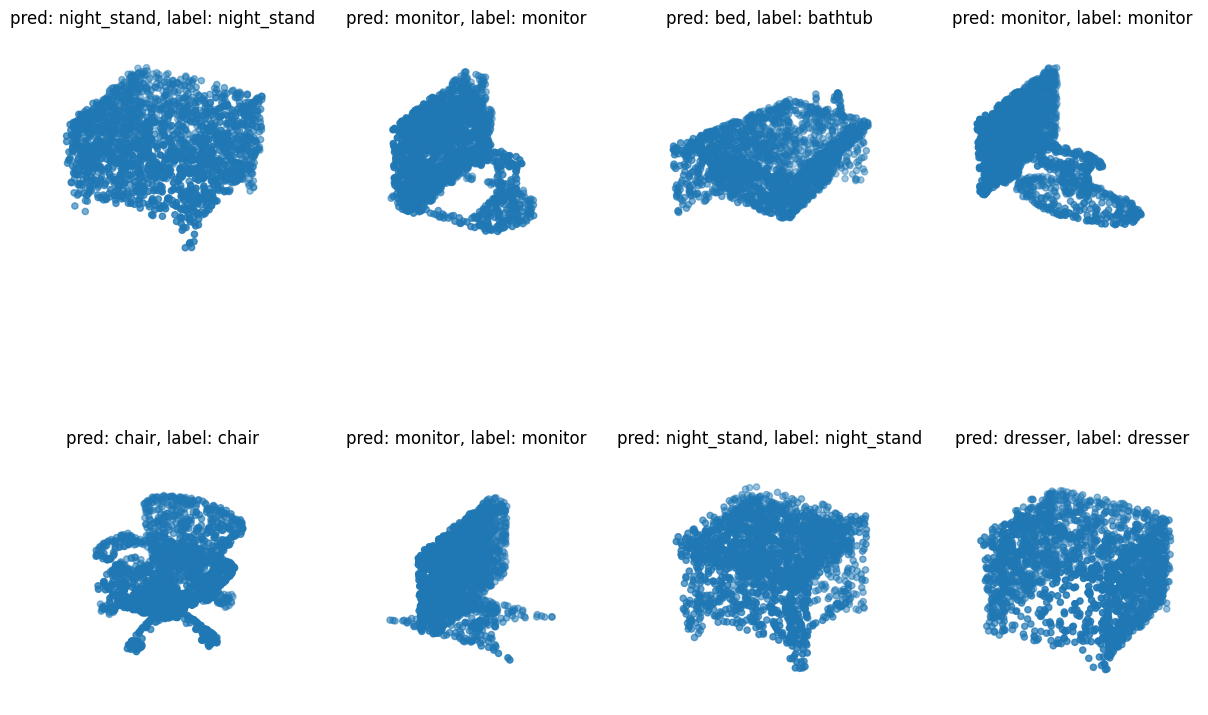

In [38]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

By looking at what the model made, just an incorrect prediction for one of the
samples, classifying a bathtub as a bed. This indicates that while the model performs reasonably well, there are still some misclassifications. To improve the model's accuracy, we might consider further fine-tuning the model, adding more training data, or using more advanced data augmentation techniques to help the model better distinguish between similar classes :)